# Shen NEI Solver
Use CHIANTI ionization and recombination data to solve ionization fraction equations using eigenvalue method of Shen et al. (2015)

In [1]:
import os

import numpy as np
import scipy.interpolate
from scipy.io import readsav
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.colors
#import mpld3
import seaborn.apionly as sns
from astropy.utils.console import ProgressBar
import hissw
os.environ['XUVTOP'] = '/Users/willbarnes/ssw/packages/chianti/dbase/'
import ChiantiPy.core as ch

from synthesizAR.atomic import solve_nei_populations
from synthesizAR.util import InputHandler, OutputHandler

%matplotlib inline
#mpld3.enable_notebook()

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


 using cli
 using CLI for selections


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Sample Temperature and Density Curves
First, make synthetic temperature and density evolution.

In [8]:
t = np.linspace(0,30,10000)
timescale_T = 15
timescale_n = 15
T_max,T_min = 1.5e7,5e4
n_max,n_min = 1.5e10,1e8
T = np.where(t>2*timescale_T,T_min,
             np.where(t<timescale_T,t*(T_max-T_min)/timescale_T+T_min,(timescale_T-t)*(T_max-T_min)/timescale_T+T_max))
n = np.where(t>2*timescale_n,n_min,
             np.where(t<timescale_n,t*(n_max-n_min)/timescale_n+n_min,(timescale_n-t)*(n_max-n_min)/timescale_n+n_max))

Load it from the IonPopSolver test run

In [9]:
tmp = np.loadtxt('/Users/willbarnes/Documents/work/codes/IonPopSolver/test/Tt_nt_1.txt',skiprows=1)
t = tmp[:,0]
T = tmp[:,1]
n = tmp[:,2]
#tnew = np.linspace(t[0],t[-1],1000)
#T = np.interp(tnew,t,T)
#n = np.interp(tnew,t,n)
#t = tnew

Run the IonPopSolver code so we can compare with our new method

In [3]:
%%bash
/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run -Z 26 -f 2 -t 28 \
-I /Users/willbarnes/Documents/work/codes/IonPopSolver/test/Tt_nt_1.txt \
-O /Users/willbarnes/Documents/work/codes/IonPopSolver/test/test1.out \
-r /Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml

0%|         |100%
  |||||||||||

The process took 6.000000 seconds to run.


In [10]:
tmp = np.loadtxt('/Users/willbarnes/Documents/work/codes/IonPopSolver/test/test1.out')

In [11]:
t_ips = tmp[:,0]
y_ips = tmp[:,4:]

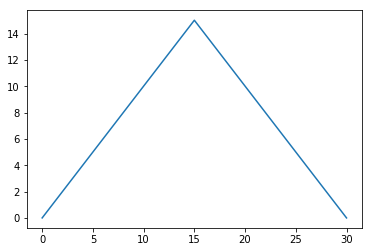

In [12]:
plt.plot(t,T/1e6)

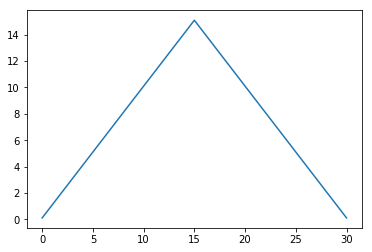

In [13]:
plt.plot(t,n/1e9)

## Ionization and Recombination Rates
Calculate ionization and recombination rates for Fe for all ions

In [14]:
temperature_grid = 10.**(np.arange(4,9+0.01,0.01))

In [15]:
Z = 26

In [16]:
ionization_rates = np.zeros(temperature_grid.shape+(Z+1,))
recombination_rates = np.zeros(temperature_grid.shape+(Z+1,))
ieq_initial = np.zeros(temperature_grid.shape+(Z+1,))

In [17]:
with ProgressBar(Z+1,ipython_widget=True) as progress:
    for i in range(1,Z+2):
        ion = ch.ion('fe_{}'.format(i),temperature=temperature_grid)
        ion.ionizRate()
        ionization_rates[:,i-1] = ion.IonizRate['rate']
        ion.recombRate()
        recombination_rates[:,i-1] = ion.RecombRate['rate']
        #ion.ioneqOne()
        #ieq_initial[:,i-1] = ion.IoneqOne
        progress.update()

A Jupyter Widget

In [18]:
tmp = ch.ioneq('Fe')
tmp.calculate(temperature_grid)
ieq_initial = tmp.Ioneq.T

Reshape the ionization and recombination rates into a block-tridiagonal matrix

In [19]:
a_matrix = np.zeros(temperature_grid.shape+(Z+1,Z+1,))
for i in range(1,Z):
    a_matrix[:,i,i] = -(ionization_rates[:,i+1] + recombination_rates[:,i])
    a_matrix[:,i,i-1] = ionization_rates[:,i]
    a_matrix[:,i,i+1] = recombination_rates[:,i+1]
a_matrix[:,0,0] = -ionization_rates[:,1]
a_matrix[:,0,1] = recombination_rates[:,1]
a_matrix[:,Z,Z] = -recombination_rates[:,Z-1]
a_matrix[:,Z,Z-1] = ionization_rates[:,Z-1]

Find the eigenvalues and eigenvectors at every temperature

In [20]:
a_eigval,a_eigvec = np.linalg.eig(a_matrix)

Now, we need to find the indices in the temperature grid corresponding to the closest values in our sample temperature.

In [21]:
eig_indices = [np.abs(temperature_grid - i).argmin() for i in T]

Plot the ionization and recmobination rates and the ionization equilibrium

In [ ]:
colors = sns.color_palette('hls',Z+1)
plt.figure(figsize=(12,8))
for i in range(1,Z+1):
    plt.plot(temperature_grid,ionization_rates[:,i],'-',color=colors[i],label='Fe {}'.format(i))
    plt.plot(temperature_grid,recombination_rates[:,i],'--',color=colors[i])
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-15,1e-8])
plt.xlim([1e4,1e9])
plt.legend(loc='best',frameon=False,ncol=2)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(temperature_grid,ieq_initial)
plt.xscale('log')

## Timestep

In [ ]:
plt.plot(t,1/np.fabs(a_eigval).max(axis=1)[eig_indices]/n)
plt.axhline(y=np.diff(t)[0],color='k',ls='--')
plt.yscale('log')

## Explicit Method -- synthesizAR
Test the method we implemented in our synthesizAR framework. This seems like it is wrong...

In [ ]:
y_exp = solve_nei_populations(t,T,n,ionization_rates,recombination_rates,ieq_initial,temperature_grid)

## Eigenvalue Method
Now, we want to actually solve our equations using the method of Shen et al. (2015)

In [25]:
y = np.zeros(T.shape+(Z+1,))
y[0,:] = ieq_initial[eig_indices[0],:]
#y[0,:] = np.where(y[0,:]<1e-6,0,y[0,:])

In [26]:
for i in range(1,t.shape[0]):
    dt = t[i] - t[i-1]
    ei = eig_indices[i]
    inv = scipy.linalg.inv(a_eigvec[eig_indices[i-1],:,:])
    y[i,:] = y[i-1,:] @ inv @ np.exp(n[i]*dt*a_eigval[ei,:]*np.eye(Z+1)) @ a_eigvec[ei]
    #y[i,:] /= y[i,:].sum()
    #y[i,:] = np.where(y[i,:]<1e-6,0,y[i,:])

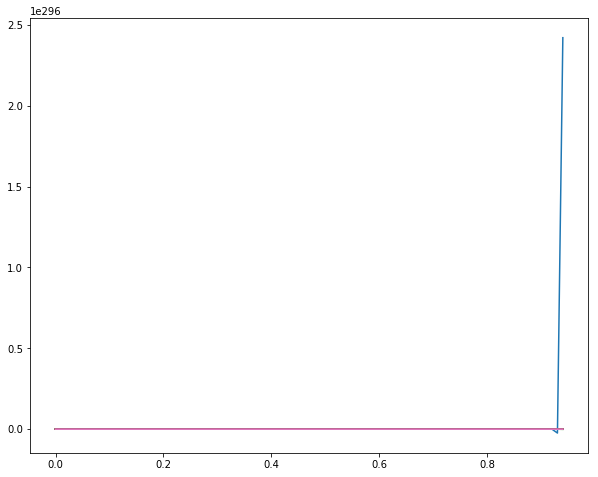

In [32]:
plt.figure(figsize=(10,8))
plt.plot(t,y);
#plt.ylim([0,1])
#plt.xlim([0,1])

## Implicit Method
Now, use the implicit method inspired by Macneice et al. (1984)

In [33]:
y_implicit = np.zeros(t.shape+(Z+1,))
y_implicit[0,:] = ieq_initial[eig_indices[0],:]

In [34]:
for i in range(1,t.shape[0]):
    dt = t[i] - t[i-1]
    term1 = np.eye(Z+1) - n[i]*dt/2.*a_matrix[eig_indices[i],:,:]
    term2 = np.eye(Z+1) + n[i-1]*dt/2.*a_matrix[eig_indices[i-1],:,:]
    y_implicit[i,:] = np.linalg.inv(term1) @ term2 @ y_implicit[i-1,:]

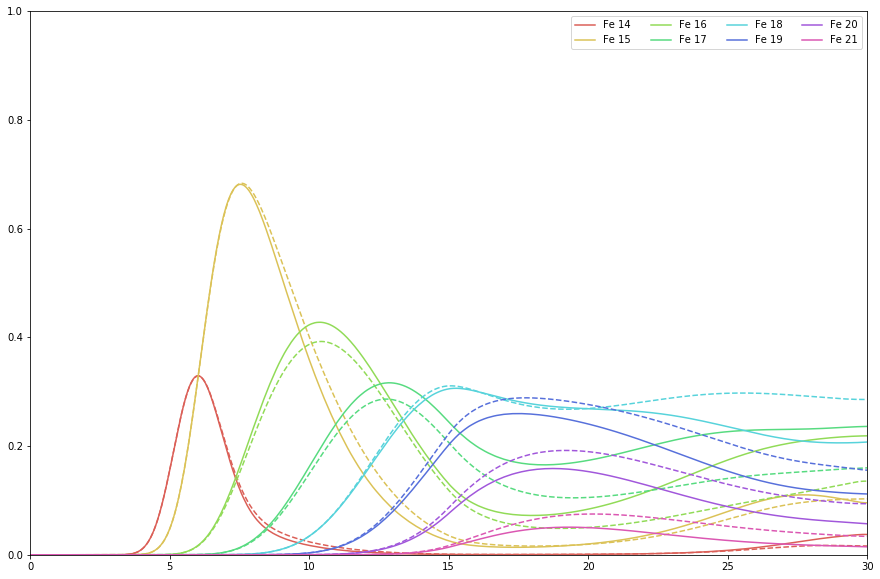

In [42]:
plt.figure(figsize=(15,10))
selection = [14,15,16,17,18,19,20,21]#list(range(Z+1))
colors = sns.color_palette('hls',len(selection))
for i,c in zip(selection,colors):
    plt.plot(t,y_implicit[:,i],color=c,label='Fe {}'.format(i))
    plt.plot(t_ips,y_ips[:,i],color=c,ls='--')
    #plt.plot(t,y_exp[:,i],color=c,ls='-.')
    #plt.plot(t,ieq_initial[eig_indices,i],ls=':',color=c)
plt.ylim([0,1])
plt.xlim([t[0],t[-1]])
plt.legend(loc='best',ncol=4)

## EBTEL Test
Run an EBTEL simulation, compute the resulting ionization fractions using three methods:

1. Method of Bradshaw (2009)
2. Implicit method

In [ ]:
base_config = InputHandler('/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml').lookup_vars()

In [ ]:
base_config['heating']['events'] = [
    {'event':{'decay_start':100,'decay_end':200,'rise_start':0,'rise_end':100,'magnitude':0.1}},
    #{'event':{'decay_start':2600,'decay_end':2700,'rise_start':2500,'rise_end':2600,'magnitude':0.5}}
]
base_config['output_filename'] = 'ebtel_test'
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = False
base_config['adaptive_solver_error'] = 1e-6
base_config['adaptive_solver_safety'] = 0.5
base_config['tau_max'] = 1000.

In [ ]:
oh = OutputHandler(base_config['output_filename']+'.xml',base_config)
oh.print_to_xml()

In [ ]:
%%bash
/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/bin/ebtel++.run -c ebtel_test.xml

In [ ]:
tmp = np.loadtxt('ebtel_test')
t_ebtel = tmp[:,0]
T_ebtel = tmp[:,1]
n_ebtel = tmp[:,3]

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.plot(t_ebtel,T_ebtel,marker='',ls='-')
ax.plot(t_ebtel,tmp[:,2],marker='',ls='--')
ax2 = ax.twinx()
#ax2.plot(t_ebtel,np.gradient(t_ebtel))
ax2.plot(t_ebtel,n_ebtel,marker='',ls='-',color='g')
ax.set_ylim([0,2e7])
#ax2.set_ylim([0,200])

Run the implicit method

In [ ]:
i_interp = [np.abs(temperature_grid - i).argmin() for i in T_ebtel]

In [ ]:
y_implicit = np.zeros(t_ebtel.shape+(Z+1,))
y_implicit[0,:] = ieq_initial[i_interp[0],:]

In [ ]:
foo = scipy.interpolate.splrep(t_ebtel,T_ebtel)

In [ ]:
scipy.interpolate.splev(np.array([100]),foo)[0]

In [ ]:
epsilon_d = 0.1
epsilon_r = 0.6
h = t_ebtel[1] - t_ebtel[0]
condition_1 = False
condition_2 = False
condition_3 = False
T_func = scipy.interpolate.interp1d(t_ebtel,T_ebtel,kind='linear',fill_value='extrapolate')
n_func = scipy.interpolate.interp1d(t_ebtel,n_ebtel,kind='linear',fill_value='extrapolate')

In [ ]:
for i in range(1,t_ebtel.shape[0]):
    all_conditions_met = False
    while not all_conditions_met:
        # Evaluate derivative
        term1 = np.eye(Z+1) - n_ebtel[i]*h/2.*a_matrix[i_interp[i],:,:]
        term2 = np.eye(Z+1) + n_ebtel[i-1]*h/2.*a_matrix[i_interp[i-1],:,:]
        y_implicit[i,:] = np.linalg.inv(term1) @ term2 @ y_implicit[i-1,:]
        y_implicit[i,:] /= y_implicit[i,:].sum()
        # Evaluate conditions
        all_conditions_met = condition_1 and condition_2 and condition_3
    # Save values

Run IonPopSolver

In [ ]:
np.savetxt('ebtel_test.ips.input',np.vstack([t_ebtel,T_ebtel,n_ebtel]).T,
           header='{}'.format(t_ebtel.shape[0]),comments='',fmt='%f\t%e\t%e')

In [ ]:
%%bash
/Users/willbarnes/Documents/work/codes/IonPopSolver/bin/IonPopSolver.run -Z 26 -f 2 -t 28 -I ebtel_test.ips.input \
-O ebtel_test.ips.output -r /Users/willbarnes/Documents/work/codes/IonPopSolver/test/radiation.local.cfg.xml

In [ ]:
tmp = np.loadtxt('ebtel_test.ips.output')
t_ips = tmp[:,0]
y_ips = tmp[:,4:]

Compare results

In [ ]:
plt.figure(figsize=(15,10))
selection = [10,11,12,20]#list(range(Z+1))
colors = sns.color_palette('hls',len(selection))
for i,c in zip(selection,colors):
    plt.plot(t_ebtel,y_implicit[:,i],color=c,label='Fe {}'.format(i+1))
    plt.plot(t_ips,y_ips[:,i],color=c,ls='--')
    plt.plot(t_ebtel,ieq_initial[i_interp,i],ls=':',color=c)
plt.ylim([0,0.5])
plt.xlim([t_ebtel[0],100])#t_ebtel[-1]])
plt.legend(loc='best',ncol=4)

## Shen Eigenvectors/values

In [ ]:
sswidl = hissw.ScriptMaker(extra_paths=['/Users/willbarnes/Documents/work/projects/time_dependent_fortran/idl_branch/'])
save_vars = ['eqistate','eigenvalues','eigenvectors','eigenvectors_invers','c_rate','r_rate']

In [ ]:
script = """
nte=501
natom=26
elemt='Fe'
eigenpath='/Users/willbarnes/Documents/work/projects/time_dependent_fortran/example/chianti_7_te501/'
openr,lun,eigenpath+string(elemt)+'eigen.dat',/get_lun,/f77_unformatted
;readu,lun,nte
;te_arr      = dblarr(nte)
eqistate    = dblarr(natom+1,nte)
eigenvalues = dblarr(natom+1,nte)
eigenvectors = dblarr(natom+1,natom+1,nte)
eigenvectors_invers = dblarr(natom+1,natom+1,nte)
c_rate      = dblarr(natom+1,nte)
r_rate      = dblarr(natom+1,nte)
;readu,lun,te_arr
readu,lun,eqistate
readu,lun,eigenvalues
readu,lun,eigenvectors
readu,lun,eigenvectors_invers
readu,lun,c_rate
readu,lun,r_rate
free_lun,lun
"""

In [ ]:
idl_res = sswidl.run([(script,{})],save_vars=save_vars,)

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(20,20))
axes[0,0].pcolor(np.fabs((idl_res['eigenvalues'])),
                 norm=matplotlib.colors.SymLogNorm(1e-30,vmin=1e-13,vmax=1e-7))
axes[0,0].set_title(r'Shen')
axes[0,1].pcolor(np.fabs((a_eigval)),
                 norm=matplotlib.colors.SymLogNorm(1e-30,vmin=1e-13,vmax=1e-7))
axes[0,1].set_title(r'Barnes')
axes[1,0].pcolor(np.fabs(np.sort(idl_res['eigenvalues'],axis=1)),
                 norm=matplotlib.colors.SymLogNorm(1e-30,vmin=1e-13,vmax=1e-7))
axes[1,1].pcolor(np.fabs(np.sort(a_eigval,axis=1)),
                 norm=matplotlib.colors.SymLogNorm(1e-30,vmin=1e-13,vmax=1e-7))

In [ ]:
plt.figure(figsize=(12,5))
opts = {'histtype':'step','lw':2,'log':True,'bins':np.logspace(-30,-8,1000)}
plt.hist(np.fabs(a_eigval.flatten()),**opts,label='Barnes');
plt.hist(np.fabs(idl_res['eigenvalues'].flatten()),**opts,label='Shen');
plt.legend()

In [ ]:
diff = a_eigvec[0,:,:] - idl_res['eigenvectors'][0,:,:]
err = np.fabs(diff)/np.where(idl_res['eigenvectors'][0,:,:]==0,1,idl_res['eigenvectors'][0,:,:])
plt.imshow(err,norm=matplotlib.colors.SymLogNorm(1e-1,vmin=-10,vmax=10))
plt.colorbar()

In [ ]:
fig = plt.figure(figsize=(12,5))
cax = fig.add_axes([0.95,0.01,0.02,1])
i_select = 250
norm = matplotlib.colors.SymLogNorm(1e-1,vmin=-1e1,vmax=1e1)
ax = fig.add_subplot(1,2,1)
ax.set_title('Shen')
ax.imshow(idl_res['eigenvectors'][i_select,:,:],norm=norm)
ax = fig.add_subplot(1,2,2)
ax.set_title('Barnes')
im = ax.imshow(a_eigvec[i_select,:,:],norm=norm)
fig.colorbar(im,cax=cax)

## MWE
Condense all steps into one runnable cell. File issue on GitHub with time-dep-ionization repo.